Import libraries

In [1]:
import sys
import importlib
sys.path.insert(0, '../')

import mortalityForecast as mf

import matplotlib.pyplot as plt
import numpy as np

Set parameters

In [2]:
param = {
    'country' : mf.data_loader.SWEDEN,
    'first_year_train' : 1952,
    'last_year_train' : 2011,
    'first_year_test' : 2012,
    'last_year_test' : 2021,
    'sex' : "Male", # or Female, Both
    'max_age' : 100,
    'model' : 'linear',
    'nn_layers' : 1,
    'latent_dim' : 3
}

model_string = "%s_%s_%d_%d_%s_%d_%d_%d" %(param['country'].name, 'linear', param['first_year_train'], param['last_year_train'], param['sex'], param['max_age'], param['nn_layers'], param['latent_dim'])
file_name = "../trainedModelsLinear/" + model_string
    
fig_path = "../manuscript/figs/"

Load data

In [3]:
exposure_all, deaths_all = mf.load_data(param, train = True, test = True)
exposure_train, deaths_train = mf.load_data(param, train = True, test = False)
exposure_test, deaths_test = mf.load_data(param, train = False, test = True)

Create model

In [4]:
model = mf.Mortality(param)

Load already trained model

In [5]:
file_name

'../trainedModelsLinear/sweden_linear_1952_2011_Male_100_1_3'

In [6]:
model = model.load(file_name = file_name, exposure = exposure_train, deaths = deaths_train )

Plot the smoothed factors against time

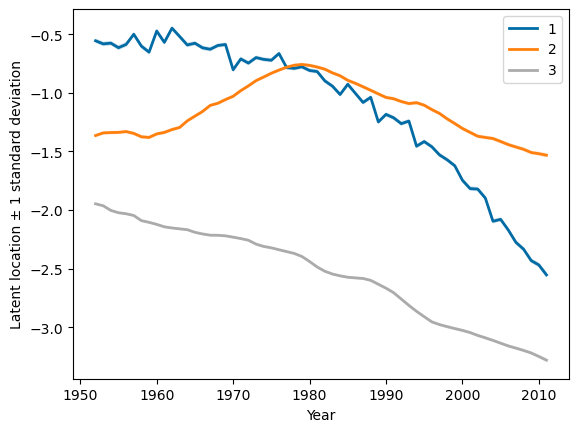

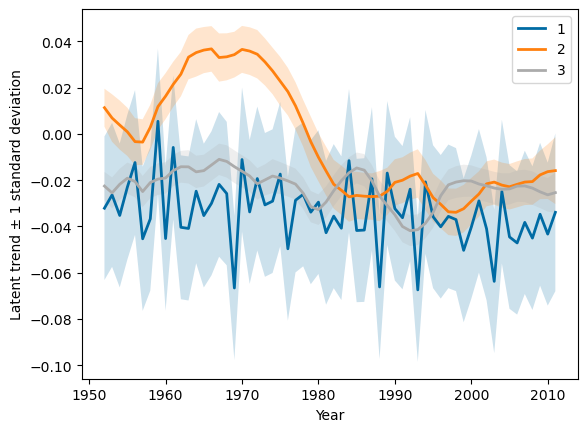

In [7]:
plt.style.use('tableau-colorblind10')

level_loc = model.level_loc
level_scale = model.level_scale

trend_loc = model.trend_loc
trend_scale = model.trend_scale

fig, ax = plt.subplots()
for i in range(level_loc.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_train']+1), level_loc[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_train']+1), 
                    level_loc[i] - level_scale[i], 
                    level_loc[i] + level_scale[i], 
                    alpha = 0.2,
                    label='_nolegend_')

plt.xlabel ('Year')
plt.ylabel ('Latent location ± 1 standard deviation')
legend_strings = [str(x) for x in range(1, 1 + level_loc.shape[0])]
plt.gca().legend(legend_strings)

fig.savefig(fig_path + model_string + "latent_level.pdf", bbox_inches='tight', dpi=1200, format = 'pdf')


fig, ax = plt.subplots()
for i in range(level_loc.shape[0]):
    ax.plot(range(param['first_year_train'],param['last_year_train']+1), trend_loc[i], linewidth = 2)
    ax.fill_between(range(param['first_year_train'],param['last_year_train']+1), 
                    trend_loc[i] - trend_scale[i], 
                    trend_loc[i] + trend_scale[i], 
                    alpha = 0.2, 
                    label='_nolegend_')

plt.xlabel ('Year')
plt.ylabel ('Latent trend ± 1 standard deviation')
plt.gca().legend(legend_strings)

fig.savefig(fig_path + model_string + "latent_trend.pdf", bbox_inches='tight', dpi=1200, format = 'pdf')

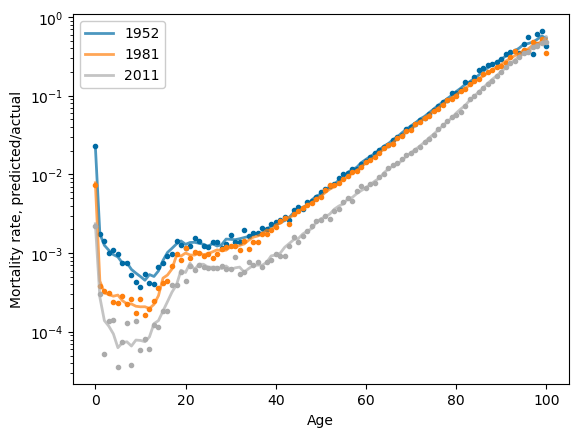

In [8]:
plt.style.use('tableau-colorblind10')

fig, ax = plt.subplots()

times = [0,
         int((param['last_year_train'] - param['first_year_train'])/2),
         param['last_year_train'] - param['first_year_train']]

mc = model.mortality_curve

for time in times:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(mc(time), color = color, linewidth = 2, alpha = 0.7, label = '%d' % (param['first_year_train'] + time))
    plt.plot(deaths_train[time,:]/exposure_train[time,:],'.', color = color, alpha = 1.0)

plt.yscale('log')
plt.xlabel ('Age')
plt.ylabel ('Mortality rate, predicted/actual')
plt.legend(framealpha=1.0, frameon=True);

plt.savefig(fig_path + model_string + "rateVsAge.pdf", bbox_inches='tight', dpi=1200, format = 'pdf')

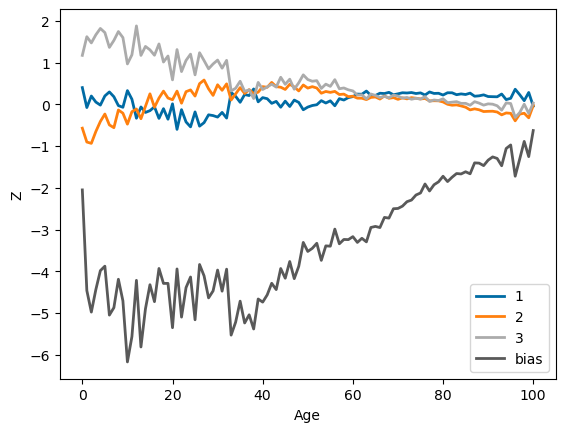

In [9]:
for factor in model.factor_loadings[1:]:
    plt.plot(factor, linewidth = 2)
plt.plot(model.factor_loadings[0], linewidth = 2)

plt.xlabel ('Age')
plt.ylabel ('Z')
legend_strings = [str(x) for x in range(1, len(model.factor_loadings))] + ['bias']
plt.gca().legend(legend_strings)
plt.savefig(fig_path + model_string + "loadings.pdf", bbox_inches='tight', dpi=1200, format = 'pdf')


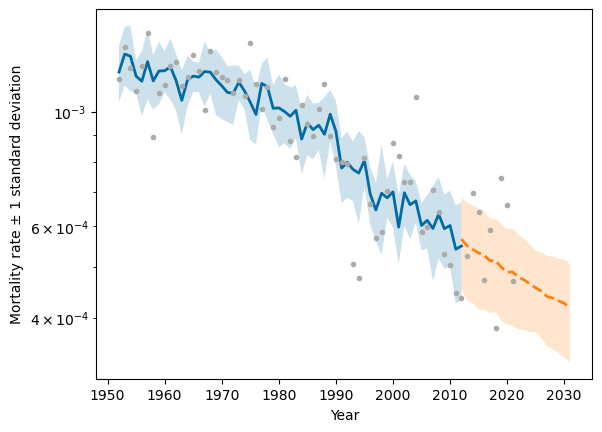

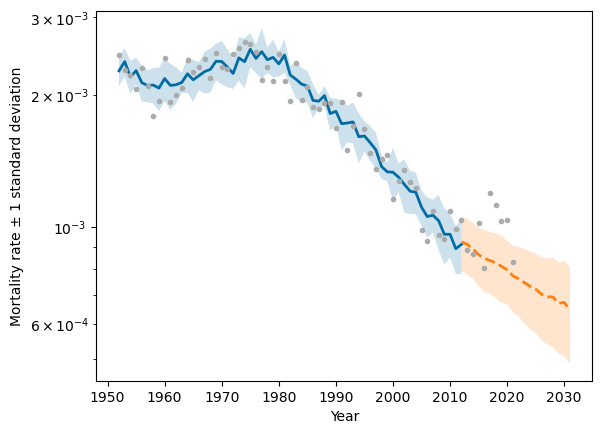

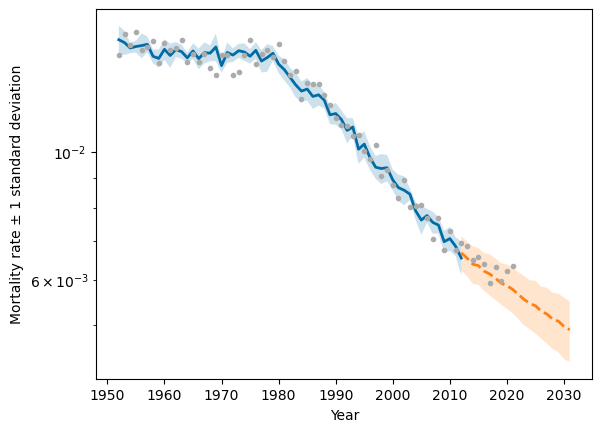

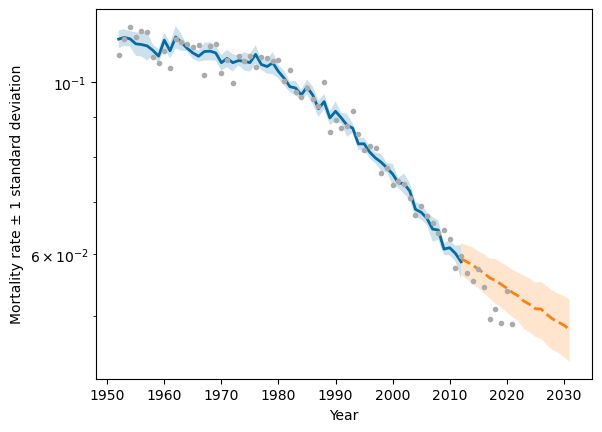

In [15]:
ages = [20, 40, 60, 80]

forecast_length = 20
mc_samples = 10

for age in ages:

    mean, scale = model.mortality(age, mc_samples = mc_samples)
    mean_f, scale_f, quantiles_f = model.forecast_mortality_rate(age = age, forecast_length = forecast_length, mc_samples = 1000)

    fig, ax = plt.subplots()

    ax.plot(
        range(param['first_year_train'], param['last_year_train'] + 2), 
        np.append(mean , mean_f[1]), 
        linewidth = 2
        )
    ax.plot(
        range(param['last_year_train'] +1 , 
              param['last_year_train'] + forecast_length + 1), 
              mean_f, 
              '--',
              linewidth = 2
              )
    ax.fill_between(
        range(param['first_year_train'], param['last_year_train'] + 2), 
        np.append(mean , mean_f[1]) - np.append(scale , scale_f[1]), 
        np.append(mean , mean_f[1]) + np.append(scale , scale_f[1]), 
        alpha=0.2
        )
    ax.fill_between(
        range(param['last_year_train'] +1 , 
              param['last_year_train'] + forecast_length + 1), 
              mean_f - scale_f, 
              mean_f + scale_f, 
              alpha=0.2
              )
    ax.plot(
        range(param['first_year_train'], 
              param['last_year_test'] + 1), 
              deaths_all[:,age]/exposure_all[:,age],
              '.'
              )

    #plt.title("Age " + str(age))
    plt.yscale('log')
    plt.xlabel ('Year')
    plt.ylabel ('Mortality rate ± 1 standard deviation')
    fig.savefig(fig_path+ model_string + "rateVsTimeAge" + str(age) + ".pdf", bbox_inches='tight', dpi=1200, format = 'pdf')
    

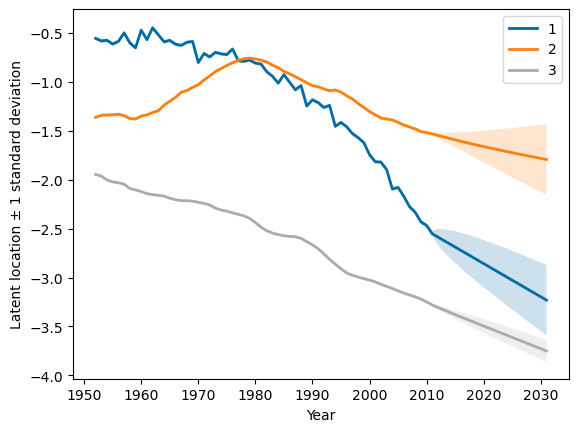

In [11]:
(fcast_mean, fcast_scale) = model.forecast_factors(forecast_length = 20)

level = np.concatenate((model.level_loc, fcast_mean), axis = 1 )
scale = np.concatenate((model.level_scale, fcast_scale), axis = 1 )

fig, ax = plt.subplots()

for i in range(level.shape[0]):
    ax.plot(range(param['first_year_train'], param['last_year_train'] + forecast_length + 1), 
            level[i], 
            linewidth = 2)
    ax.fill_between(
        range(param['first_year_train'], param['last_year_train'] + forecast_length + 1), 
        level[i] - scale[i], 
        level[i] + scale[i],
        alpha=0.2,
        label='_nolegend_')

plt.xlabel ('Year')
plt.ylabel ('Latent location ± 1 standard deviation')
plt.gca().legend(('1','2','3'))

fig.savefig(fig_path + model_string + "latent_forecast.pdf", bbox_inches='tight', dpi=1200, format = 'pdf')

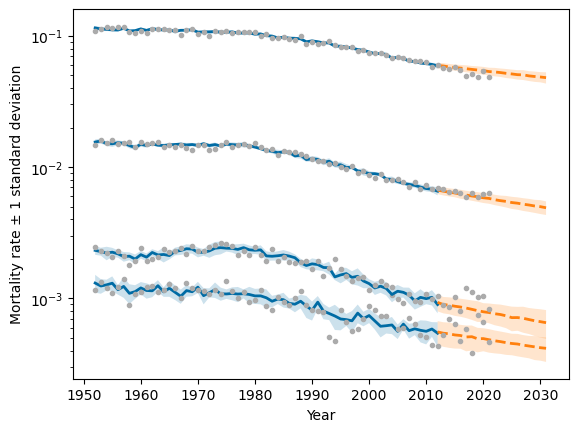

In [13]:
ages = [20, 40, 60, 80]

forecast_length = 20
mc_samples = 10
fig, ax = plt.subplots()

for age in ages:

    plt.gca().set_prop_cycle(None)

    mean, scale = model.mortality(age, mc_samples = mc_samples)
    mean_f, scale_f, quantiles_f = model.forecast_mortality_rate(age = age, forecast_length = forecast_length, mc_samples = 1000)

    ax.plot(
        range(param['first_year_train'], param['last_year_train'] + 2), 
        np.append(mean , mean_f[1]), 
        linewidth = 2
        )
    ax.plot(
        range(param['last_year_train'] +1 , 
              param['last_year_train'] + forecast_length + 1), 
              mean_f, 
              '--',
              linewidth = 2,
              )
    ax.fill_between(
        range(param['first_year_train'], param['last_year_train'] + 2), 
        np.append(mean , mean_f[1]) - np.append(scale , scale_f[1]), 
        np.append(mean , mean_f[1]) + np.append(scale , scale_f[1]), 
        alpha=0.2
        )
    ax.fill_between(
        range(param['last_year_train'] +1 , 
              param['last_year_train'] + forecast_length + 1), 
              mean_f - scale_f, 
              mean_f + scale_f, 
              alpha=0.2
              )
    ax.plot(
        range(param['first_year_train'], 
              param['last_year_test'] + 1), 
              deaths_all[:,age]/exposure_all[:,age],
              '.'
              )

    #plt.title("Age " + str(age))
plt.yscale('log')
plt.xlabel ('Year')
plt.ylabel ('Mortality rate ± 1 standard deviation')

fig.savefig(fig_path + model_string + "rateVsTime" + ".pdf", bbox_inches='tight', dpi=1200, format = 'pdf')
    